In [235]:
import matplotlib.pyplot as plt
import sys, os
import matplotlib.mlab as mlab
import scipy
from skimage import measure
from skimage.io import imread

import cv2 as cv
import numpy as np
from skimage import measure, morphology
from sklearn.cluster import KMeans

68


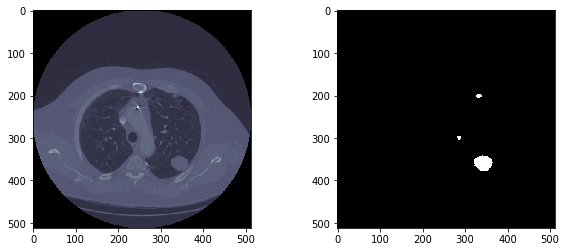

In [461]:
# 1.3: visualize

idx = np.random.randint(len(os.listdir('../data/prepared/image')))

# hard images: 45, 59, 60, 68, 73
idx = 68




img = imread(f'../data/prepared/image/{idx}.tif') 
mask = imread(f'../data/prepared/label/{idx}.tif') 

print(idx)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(np.array(img), cmap='bone')
axs[1].imshow(np.array(mask), cmap='bone')
plt.show()

In [462]:
def get_lung_mask(img):

    # threshold for haunsfield units
    img = cv.normalize(
        img,
        np.zeros(img.shape),
        -1200,
        600,
        cv.NORM_MINMAX
    )

    mean = np.mean(img)
    std = np.std(img)
    # img = img-mean
    # img = img/std

    # Find the average pixel value near lungs to renormalize washed out images
    middle = img[100:400,100:400] 
    mean = np.mean(middle)  
    max_im = np.max(img)
    min_im = np.min(img)
    
    # Moving underflow and overflow on pixel spectrum to improve threshold finding
    img[img==max_im]=mean
    img[img==min_im]=mean
    
    # Use Kmeans to separate foreground (radio-opaque tissue) and background (radio transparent tissue ie lungs)
    # Do only on the center of the image to avoid non-tissue parts of the image as much as possible
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image

    
    # Erosion to remove graininess from some of the regions
    eroded = morphology.erosion(thresh_img,np.ones([2,2]))
    
    # Dialation to make the lung region engulf the vessels and incursions into the lung cavity by 
    # radio opaque tissue
    dilation = morphology.dilation(eroded,np.ones([10, 10]))

    #  1. Label each region and obtain the region properties
    #  2. Background region removed by removing regions w/ large bbox
    #  3. Remove regions close to top and bottom of image (far from lungs)
    labels = measure.label(dilation)
    label_vals = np.unique(labels)
    regions = measure.regionprops(labels)
    good_labels = []
    for prop in regions:
        B = prop.bbox
        if B[2]-B[0]<475 and B[3]-B[1]<475 and B[0]>40 and B[2]<475:
            good_labels.append(prop.label)
    mask = np.ndarray([512,512],dtype=np.int8)
    mask[:] = 0

    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
        mask = morphology.dilation(mask,np.ones([4,4])) # one last dilation

    mask[mask > 0] = 1
    
    # fill holes 
    mask = np.float32(scipy.ndimage.morphology.binary_fill_holes(mask))
    
    # shrink edges with final erosion
    mask = morphology.erosion(mask,np.ones([15,15]))
    return mask

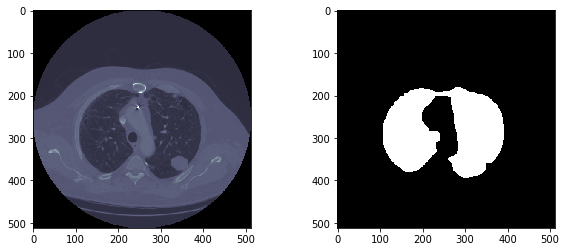

In [463]:
mask = get_lung_mask(img)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(np.array(img), cmap='bone')
axs[1].imshow(np.array(mask), cmap='bone')
plt.show()


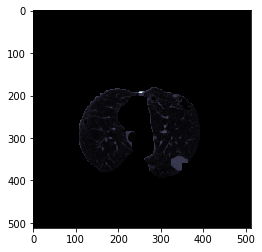

In [464]:
plt.imshow(mask*img, cmap='bone')

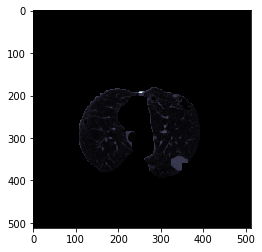

In [465]:
plt.imshow(mask*img, cmap='bone')